In [1]:
import pandas as pd
import random
import IPython.display as ipd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from tqdm import tqdm
import torchaudio

In [2]:
df = pd.read_csv('../input/birdclef-2022/train_metadata.csv')
df.sample(10)

primary_label secondary_labels  \
7526         japqua               []   
14147        wesmea               []   
12085        rorpar               []   
11526        rinphe               []   
9141         norcar               []   
10439        osprey               []   
7796        leater1               []   
13804        sposan               []   
7426           iiwi               []   
2841        caster1               []   

                                                    type  latitude  longitude  \
7526                                    ['male', 'song']   42.5275   130.6920   
14147                                   ['call', 'song']   49.1453  -107.5042   
12085                                           ['call']   50.8503     4.3517   
11526            ['call', 'female', 'male', 'wing beat']   35.4421   136.1930   
9141                                    ['call', 'song']   31.6071  -111.0410   
10439  ['life stage uncertain', 'sex uncertain', 'song']   50.7201  -120.5251   
7796                                     ['flight call']   28.2267   -80.7645   
13804                      ['alarm call', 'flight call']   47.6770   -70.8267   
7426                ['begging call', 'call', 'juvenile']   20.7690  -156.2370   
2841                                      ['alarm call']   45.9954    43.5608   

             scientific_name           common_name              author  \
7526       Coturnix japonica        Japanese Quail    Albert Lastukhin   
14147     Sturnella neglecta    Western Meadowlark  Richard E. Webster   
12085     Psittacula krameri  Rose-ringed Parakeet        Patrik Åberg   
11526    Phasianus colchicus  Ring-necked Pheasant         Anon Torimi   
9141   Cardinalis cardinalis     Northern Cardinal       Ross Gallardy   
10439      Pandion haliaetus                Osprey        Risto Milner   
7796     Sternula antillarum            Least Tern         Paul Marvin   
13804     Actitis macularius     Spotted Sandpiper    Martin St-Michel   
7426       Drepanis coccinea                  Iiwi    Thomas G. Graves   
2841      Hydroprogne caspia          Caspian Tern    Albert Lastukhin   

                                                 license  rating   time  \
7526   Creative Commons Attribution-NonCommercial-Sha...     3.5  07:00   
14147  Creative Commons Attribution-NonCommercial-Sha...     4.5  21:04   
12085  Creative Commons Attribution-NonCommercial-Sha...     4.0  09:38   
11526  Creative Commons Attribution-NonCommercial-Sha...     1.0  11:00   
9141   Creative Commons Attribution-NonCommercial-Sha...     4.0  07:30   
10439  Creative Commons Attribution-NonCommercial-Sha...     3.0  16:00   
7796   Creative Commons Attribution-NonCommercial-Sha...     4.0  13:44   
13804  Creative Commons Attribution-NonCommercial-Sha...     5.0  09:57   
7426   Creative Commons Attribution-NonCommercial-Sha...     5.0  07:10   
2841   Creative Commons Attribution-NonCommercial-Sha...     5.0  06:00   

                                     url              filename  
7526   https://www.xeno-canto.org/266703   japqua/XC266703.ogg  
14147  https://www.xeno-canto.org/185829   wesmea/XC185829.ogg  
12085  https://www.xeno-canto.org/506680   rorpar/XC506680.ogg  
11526  https://www.xeno-canto.org/216043   rinphe/XC216043.ogg  
9141   https://www.xeno-canto.org/297495   norcar/XC297495.ogg  
10439  https://www.xeno-canto.org/573688   osprey/XC573688.ogg  
7796   https://www.xeno-canto.org/177287  leater1/XC177287.ogg  
13804  https://www.xeno-canto.org/193409   sposan/XC193409.ogg  
7426   https://www.xeno-canto.org/327825     iiwi/XC327825.ogg  
2841   https://www.xeno-canto.org/365791  caster1/XC365791.ogg

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14852 entries, 0 to 14851
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     14852 non-null  object 
 1   secondary_labels  14852 non-null  object 
 2   type              14852 non-null  object 
 3   latitude          14852 non-null  float64
 4   longitude         14852 non-null  float64
 5   scientific_name   14852 non-null  object 
 6   common_name       14852 non-null  object 
 7   author            14852 non-null  object 
 8   license           14852 non-null  object 
 9   rating            14852 non-null  float64
 10  time              14852 non-null  object 
 11  url               14852 non-null  object 
 12  filename          14852 non-null  object 
dtypes: float64(3), object(10)
memory usage: 1.5+ MB


## Analyze some random audio

In [4]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import gc
from tqdm import tqdm
from IPython.display import Audio
!pip install -qq noisereduce
import noisereduce as nr
import os

In [5]:
def plot_spec(signal,sr=None, fig=None, ax=None, method='fft', show_onset=True):
    
    if fig==None or ax==None:
        fig, ax = plt.subplots()
    
    if method=='fft':
        D = librosa.stft(signal, n_fft=2048)  # STFT of y
        data = librosa.amplitude_to_db(np.abs(D), ref=np.max)
        img = librosa.display.specshow(data, x_axis='time', y_axis='log', ax=ax)
        ax.set(title='FFT Log Spectogram')
        fig.colorbar(img, ax=ax, format="%+2.f dB")
    
    if method=='mel':
        M = librosa.feature.melspectrogram(y=signal, sr=sr)
        data = librosa.power_to_db(M, ref=np.max)
        fig, ax = plt.subplots()
        img = librosa.display.specshow(data, y_axis='mel', x_axis='time', ax=ax)
        ax.set(title='Mel Spectogram')
        fig.colorbar(img, ax=ax, format="%+2.f dB")
        
    if show_onset:
        o_env = librosa.onset.onset_strength(y=signal, sr=sr)
        times = librosa.times_like(o_env, sr=sr)
        onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)
        idxs = librosa.onset.onset_detect(y=audio, sr=sr, units='samples')
        ax.vlines(times[onset_frames], 0, data.shape[1], color='b', alpha=0.9,linestyle='--', label='Onsets')
        
    return fig
    
def create_slices(length, sl, overlap=0):
    assert sl > overlap
    idx = 0
    slices = []
    while(idx < length - sl):
        slices.append((idx, idx+sl-1))
        idx += sl - overlap
    return slices

In [6]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [34]:
sr = 32_000
fmin = 100
fmax=15_000

In [8]:
random_file = random.choice(df["filename"].values) # random file
path = f"../input/birdclef-2022/train_audio/{random_file}"
df[df["filename"] == random_file]

primary_label secondary_labels                                    type  \
7359        houspa               []  ['call', 'female', 'juvenile', 'male']   

      latitude  longitude    scientific_name    common_name            author  \
7359   37.8844     -4.782  Passer domesticus  House Sparrow  Esperanza Poveda   

                                                license  rating time  \
7359  Creative Commons Attribution-NonCommercial-Sha...     4.0    ?   

                                    url             filename  
7359  https://www.xeno-canto.org/641189  houspa/XC641189.ogg

In [9]:
audio, sr = librosa.load(path, sr=sr, res_type='kaiser_fast')
audio_filtered = butter_bandpass_filter(audio, fmin, fmax,sr,5)
reducted = nr.reduce_noise(y=audio, sr=sr, stationary=True)
reducted_2 = nr.reduce_noise(y=reducted, sr=sr, stationary=False)

In [10]:
Audio(data=audio, rate=sr)

(64, 4672)


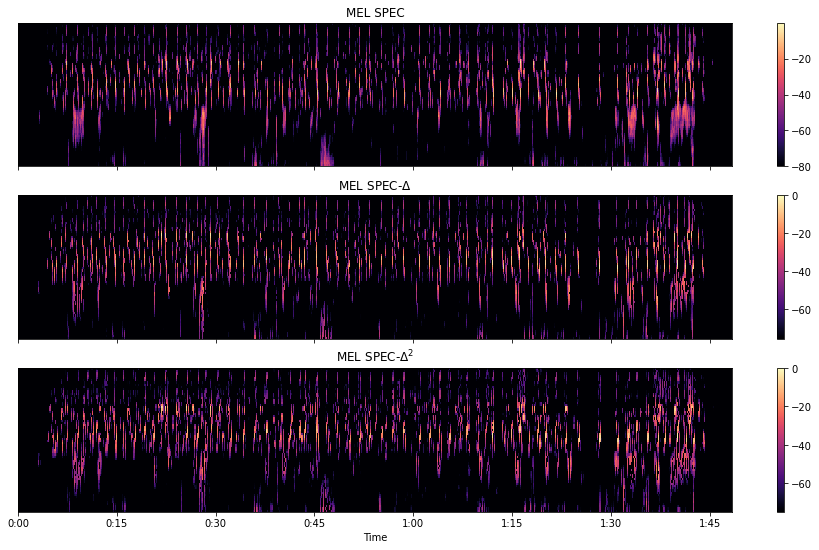

In [11]:
mfcc = librosa.feature.melspectrogram(y=reducted_2, sr=sr, fmin=fmin, fmax=fmax, n_mels=64, n_fft=1024)
mfcc_delta = librosa.feature.delta(mfcc)
mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

mfcc = librosa.power_to_db(mfcc, ref=np.max)
mfcc_delta = librosa.power_to_db(mfcc_delta, ref=np.max)
mfcc_delta2 = librosa.power_to_db(mfcc_delta2, ref=np.max)

fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(16,9))

img1 = librosa.display.specshow(mfcc, ax=ax[0], x_axis='time')

ax[0].set(title='MEL SPEC')

ax[0].label_outer()

img2 = librosa.display.specshow(mfcc_delta, ax=ax[1], x_axis='time')

ax[1].set(title=r'MEL SPEC-$\Delta$')

ax[1].label_outer()

img3 = librosa.display.specshow(mfcc_delta2, ax=ax[2], x_axis='time')

ax[2].set(title=r'MEL SPEC-$\Delta^2$')

fig.colorbar(img1, ax=[ax[0]])

fig.colorbar(img2, ax=[ax[1]])

fig.colorbar(img3, ax=[ax[2]])
print(mfcc.shape)

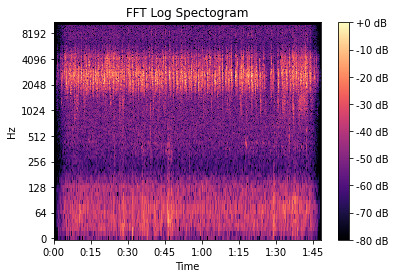

In [12]:
fig = plot_spec(audio, sr, method='fft', show_onset=False)

## Generate Numpy Dataset

In [13]:
from multiprocessing import Pool
from itertools import repeat

In [47]:
out_folder = 'numpy_mel'
!rm -r numpy_mel
os.mkdir(out_folder)

In [48]:
def convert_audio_to_numpy(name, sr):
    # load audio
    path = path = f"../input/birdclef-2022/train_audio/{name}"
    audio, sr = librosa.load(path, sr=sr, res_type='kaiser_fast')
    # filter with a butterworth bandpass
    audio_filtered = butter_bandpass_filter(audio, fmin, fmax, sr,5)
    # reduce stationary and non-stationary noise
    reduced_stat = nr.reduce_noise(y=audio_filtered, sr=sr, stationary=True)
    reduced_total = nr.reduce_noise(y=reduced_stat, sr=sr, stationary=False)
    
    # extract features
    mel_spec = librosa.feature.melspectrogram(y=reduced_total, sr=sr, fmin=fmin, fmax=fmax, n_mels=64, n_fft=1024)
    # convert to db
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    
    # create a new filename
    fname = name.replace('/', '_').replace('.ogg', '')
    fname = os.path.join(out_folder, fname)
    np.save(fname,mel_spec)

In [49]:
paths = df['filename'].values

inputs = zip(paths, repeat(sr))

with Pool(4) as pool:
    pool.starmap(convert_audio_to_numpy, inputs)

OSError: 203584 requested and 32752 written

## Dataset Class

In [81]:
class config:
    seed=2022
    num_fold = 5
    sample_rate= 32_000
    n_fft=1024
    hop_length=512
    n_mels=64
    duration=5
    num_classes = 152
    train_batch_size = 32
    valid_batch_size = 64
    model_name = 'resnet50'
    epochs = 2
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    learning_rate = 1e-4

In [82]:
encoder = LabelEncoder()
df['primary_label_encoded'] = encoder.fit_transform(df['primary_label'])

In [83]:
skf = StratifiedKFold(n_splits=config.num_fold)
for k, (_, val_ind) in enumerate(skf.split(X=df, y=df['primary_label_encoded'])):
    df.loc[val_ind, 'fold'] = k

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


In [84]:
class BirdClefDataset(Dataset):
    def __init__(self, df, transformation, target_sample_rate, duration):
        self.audio_paths = df['filename'].values
        self.labels = df['primary_label_encoded'].values
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.num_samples = target_sample_rate*duration
        
    def __len__(self):
        return len(self.audio_paths)
    
    def __getitem__(self, index):
        audio_path = f'../input/birdclef-2022/train_audio/{self.audio_paths[index]}'
        signal, sr = torchaudio.load(audio_path) # loaded the audio
        
        # Now we first checked if the sample rate is same as TARGET_SAMPLE_RATE and if it not equal we perform resampling
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        
        # Next we check the number of channels of the signal
        #signal -> (num_channels, num_samples) - Eg.-(2, 14000) -> (1, 14000)
        if signal.shape[0]>1:
            signal = torch.mean(signal, axis=0, keepdim=True)
        
        # Lastly we check the number of samples of the signal
        #signal -> (num_channels, num_samples) - Eg.-(1, 14000) -> (1, self.num_samples)
        # If it is more than the required number of samples, we truncate the signal
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        
        # If it is less than the required number of samples, we pad the signal
        if signal.shape[1]<self.num_samples:
            num_missing_samples = self.num_samples - signal.shape[1]
            last_dim_padding = (0, num_missing_samples)
            signal = F.pad(signal, last_dim_padding)
        
        # Finally all the process has been done and now we will extract mel spectrogram from the signal
        mel = self.transformation(signal)
        
        # For pretrained models, we need 3 channel image, so for that we concatenate the extracted mel
        #image = torch.cat([mel, mel, mel])
        image = mel
        
        # Normalized the image
        max_val = torch.abs(image).max()
        image = image / max_val
        
        label = torch.tensor(self.labels[index])
        
        return image, label

In [85]:
# Function to get data according to the folds
def get_data(fold):
    train_df = df[df['fold'] != fold].reset_index(drop=True)
    valid_df = df[df['fold'] == fold].reset_index(drop=True)
    
    train_dataset = BirdClefDataset(train_df, mel_spectrogram, config.sample_rate, config.duration)
    valid_dataset = BirdClefDataset(valid_df, mel_spectrogram, config.sample_rate, config.duration)
    
    train_loader = DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=config.valid_batch_size, shuffle=False)
    
    return train_loader, valid_loader

In [86]:
class BirdClefModel(nn.Module):
    def __init__(self):
        super(BirdClefModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128*8*54, 64)
        self.fc2 = nn.Linear(64, config.num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [87]:
def loss_fn(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

def train(model, data_loader, optimizer, scheduler, device, epoch):
    model.train()
    
    running_loss = 0
    loop = tqdm(data_loader, position=0)
    for i, (mels, labels) in enumerate(loop):
        mels = mels.to(device)
        labels = labels.to(device)
        
        outputs = model(mels)
        _, preds = torch.max(outputs, 1)
        
        loss = loss_fn(outputs, labels)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if scheduler is not None:
            scheduler.step()
            
        running_loss += loss.item()
        
        loop.set_description(f"Epoch [{epoch+1}/{config.epochs}]")
        loop.set_postfix(loss=loss.item())

    return running_loss/len(data_loader)

In [88]:
def valid(model, data_loader, device, epoch):
    model.eval()
    
    running_loss = 0
    pred = []
    label = []
    
    loop = tqdm(data_loader, position=0)
    for mels, labels in loop:
        mels = mels.to(device)
        labels = labels.to(device)
        
        outputs = model(mels)
        _, preds = torch.max(outputs, 1)
        
        loss = loss_fn(outputs, labels)
            
        running_loss += loss.item()
        
        pred.extend(preds.view(-1).cpu().detach().numpy())
        label.extend(labels.view(-1).cpu().detach().numpy())
        
        loop.set_description(f"Epoch [{epoch+1}/{config.epochs}]")
        loop.set_postfix(loss=loss.item())
        
    valid_f1 = f1_score(label, pred, average='macro')
    
    return running_loss/len(data_loader), valid_f1

In [89]:
def run(fold):
    train_loader, valid_loader = get_data(fold)
    
    model = BirdClefModel().to(config.device) # check version 3 for this
    
    optimizer = Adam(model.parameters(), lr=config.learning_rate)
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-5, T_max=10)
    
    best_valid_f1 = 0
    for epoch in range(config.epochs):
        train_loss = train(model, train_loader, optimizer, scheduler, config.device, epoch)
        valid_loss, valid_f1 = valid(model, valid_loader, config.device, epoch)
        if valid_f1 > best_valid_f1:
            print(f"Validation F1 Improved - {best_valid_f1} ---> {valid_f1}")
            torch.save(model.state_dict(), f'./model_{fold}.bin')
            print(f"Saved model checkpoint at ./model_{fold}.bin")
            best_valid_f1 = valid_f1
            
    return best_valid_f1

In [90]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=config.sample_rate, 
                                                      n_fft=config.n_fft, 
                                                      hop_length=config.hop_length, 
                                                      n_mels=config.n_mels,
                                                      f_min=50,
                                                      f_max=14000)

## Dataset Test

In [91]:
fold = 1
train_loader, valid_loader = get_data(fold)

In [92]:
import matplotlib.pyplot as plt
import numpy as np

length = 5.008s, max: 1.0, min: 2.4227735373472115e-09


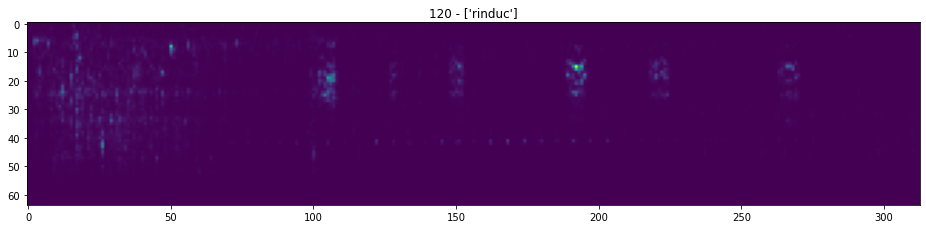

length = 5.008s, max: 1.0, min: 5.093190192512198e-12


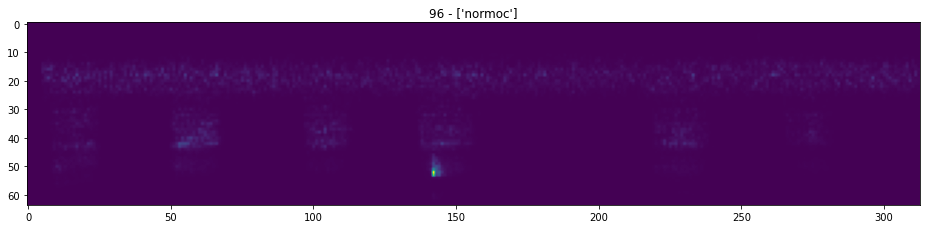

length = 5.008s, max: 1.0, min: 1.8181441934135047e-14


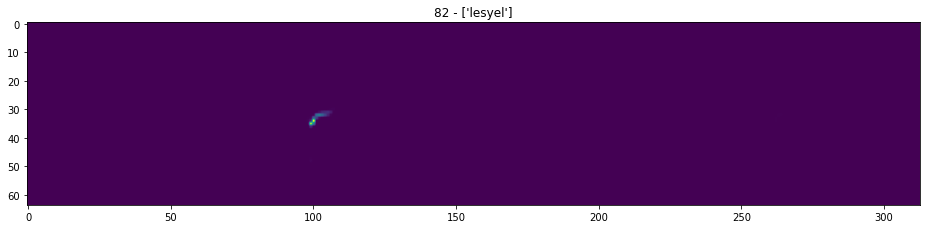

length = 5.008s, max: 1.0, min: 2.4198726789742553e-12


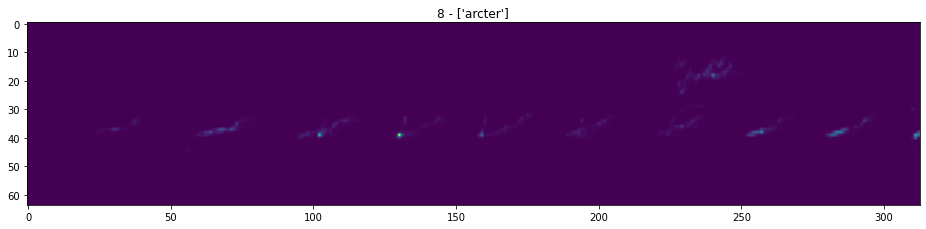

length = 5.008s, max: 1.0, min: 2.4759699845944283e-10


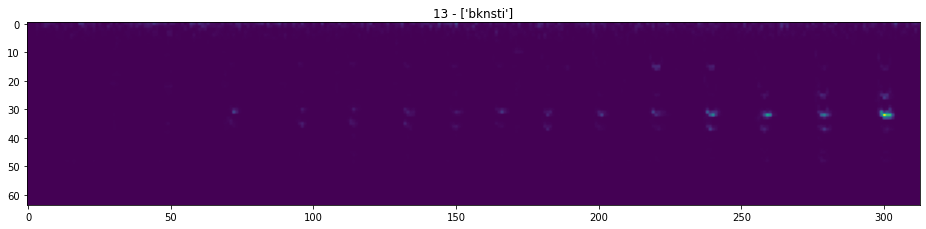

In [98]:
n_examples = 4
it = 0
for img, label in train_loader:
    batch_idx = 0
    spec = img[batch_idx].squeeze()
    length = spec.shape[1]*512 / config.sample_rate
    print(f"length = {length}s, max: {spec.max()}, min: {spec.min()}")
    plt.figure(figsize=(16,32))
    plt.imshow(spec)
    plt.title(f"{label[batch_idx]} - {encoder.inverse_transform(np.array(label[batch_idx]).reshape(1,1).ravel())}")
    plt.show()
    it += 1
    if it > n_examples:
        break

In [94]:
if False:
    for fold in range(config.num_fold):
        print("=" * 30)
        print("Training Fold - ", fold)
        print("=" * 30)
        best_valid_f1 = run(fold)
        print(f'Best F1 Score: {best_valid_f1:.5f}')

        gc.collect()
        torch.cuda.empty_cache()    
        break # To run for all the folds, just remove this break